#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

### Выгрузка 

In [3]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns 
from statsmodels.tsa.seasonal import seasonal_decompose
plt.style.use('dark_background')

Думаю не секрет,что столбец с временем нужно указывать как индекс и тип данных соответствующий.

In [4]:
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

except:
    data = pd.read_csv(r'D:\data_set\taxi.csv'
                            , index_col=[0], parse_dates=[0])

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
# чисто для проверки 
print('пропуски:',data.isna().sum())


пропуски: num_orders    0
dtype: int64


Первым делом рессемплируем по часу, требование.  

In [5]:
data = data.resample('1H').sum()
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


## Анализ

Посмотрим на графики

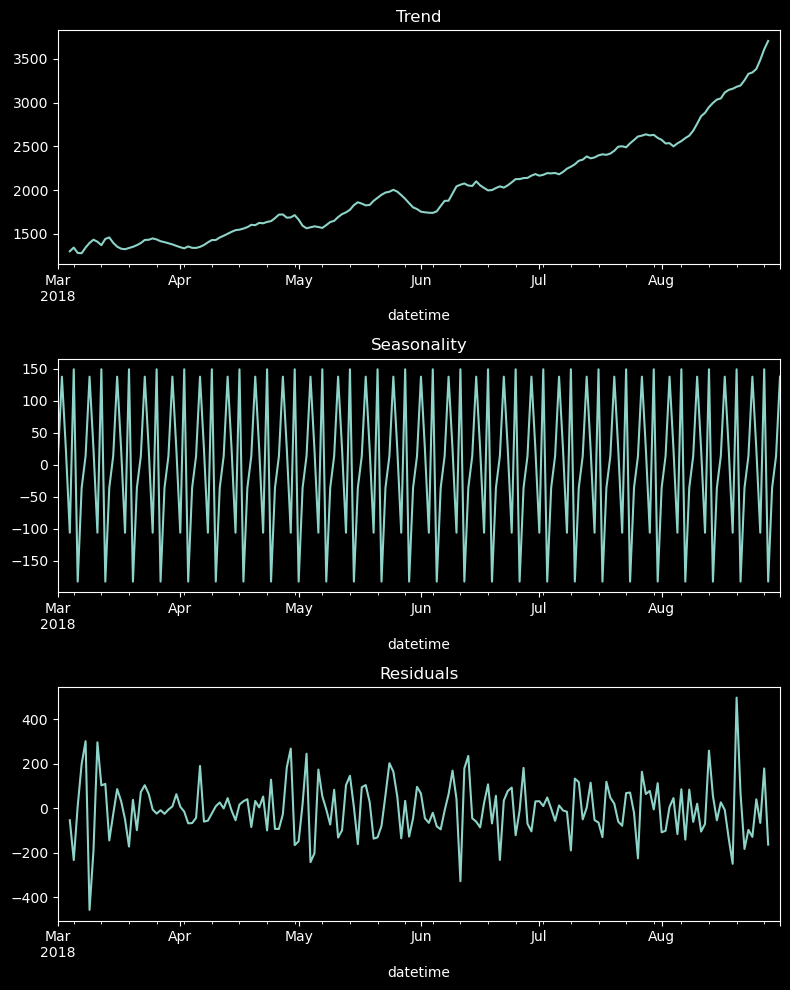

In [6]:
decomposed = seasonal_decompose(data.resample('1D').sum())
plt.figure(figsize=(8, 10))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Наблюдается устойчивый тренд на рост,так же недельная сезонность.Сейчас выведем более подробную динамику по неделям и дням.

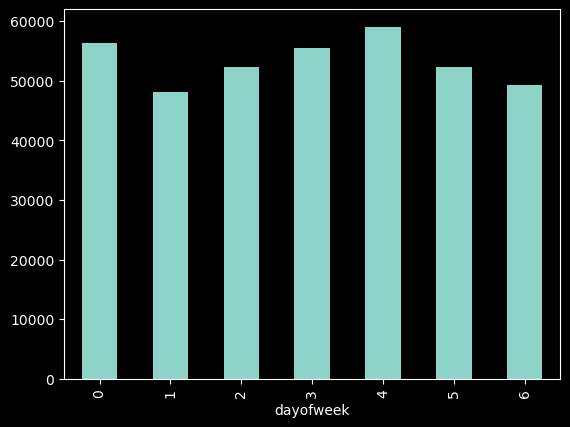

In [7]:
data['dayofweek'] = data.index.dayofweek
day_of_week = data.groupby('dayofweek')['num_orders'].sum()
day_of_week.plot(kind='bar')
plt.show()
data.drop('dayofweek',axis=1,inplace=True)


Конечно, в общем наблюдается некая связь между количеством заказов и данями недели

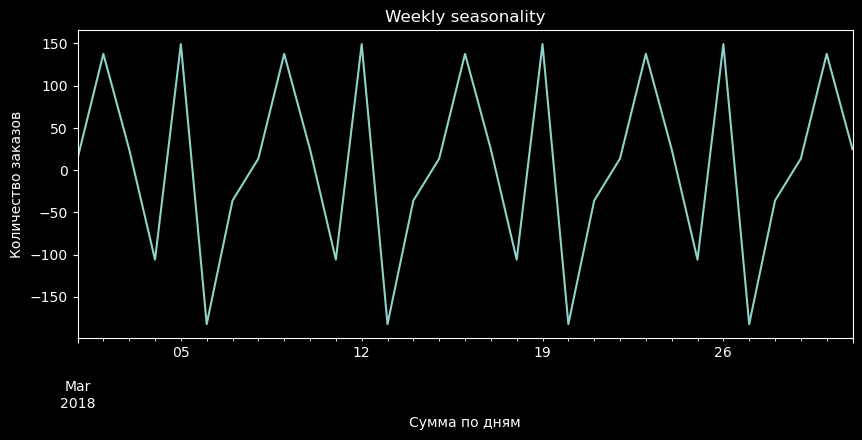

In [8]:
plt.figure(figsize=(10, 4))
decomposed.seasonal['2018-03':'2018-03'].plot(title='Weekly seasonality')
plt.xlabel("Сумма по дням")
plt.ylabel('Количество заказов')
plt.show()

Теперь посмотри на часы в днях

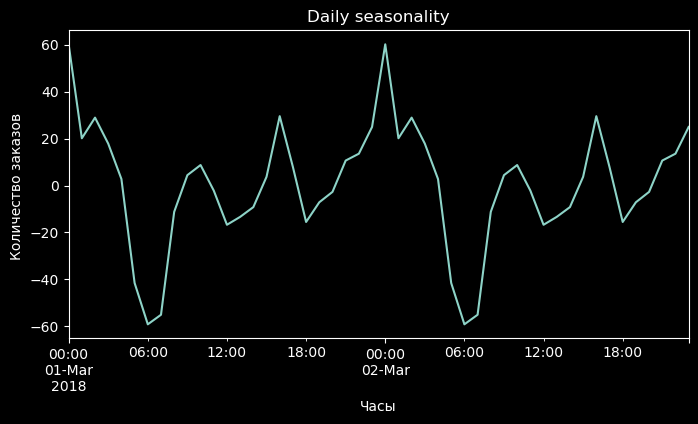

In [9]:
decomposed_h = seasonal_decompose(data)
plt.figure(figsize=(8, 4))
decomposed_h.seasonal['2018-03-01':'2018-03-02'].plot(title='Daily seasonality')
plt.xlabel("Часы")
plt.ylabel('Количество заказов ')
plt.show()

#### Создание признаков 

Аналогично, как в тренажере,создадим функцию для дня недели и часа, отставания(lag) и скользящего среднего:


In [10]:
def make_features(data, max_lag, rolling_mean_size):
    
    result = data.copy()
    
    result['dayofweek'] = data.index.dayofweek
    result['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        result['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    result['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return result

"Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час." Лаг по сути, это мера вырожденности, того настоль предыдущие события определяют настоящие.Если нам важно в конкретный час предсказать,по хорошему брать лаг в 1 час,так как предыдущие предсказывает лучше всего.Снизить колебания случайных факторов,  лучше с отставанием в 2 часа,хотя может быть,и в 3 час,что бы шум точно не влиял.Короче,медиана по 3 предложенным значениям 2,так я в среднем допущу меньшую ошибку(еще один аргумент в пользу двух часов,максимальное время часа пик).Скользящие среднее ,конечно же, = 24 - сутки.

In [11]:
new_data  = make_features(data,2,24)
new_data

,num_orders,dayofweek,hour,lag_1,lag_2,rolling_mean
datetime,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,NaN
...,...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,207.0,217.0,164.875000
2018-08-31 20:00:00,154,4,20,136.0,207.0,167.541667
2018-08-31 21:00:00,159,4,21,154.0,136.0,168.041667


**Небольшой вывод**
* Увидели растущий тренд
* Также недельную сезонность,фаворит по количеству заказов конечно пятница 
* Посмотрели динамику количества заказов по дню,к полуночи растет,и постепенно падает к 6 часам утра.Небольшие всплески в часы пик. 
* Создали признаки для предсказания модели:
   1. День недели сезонность 
   2. скользящие среднее в 24 часа 
   3. Отставание в 2 часа для наилучшего предсказания модели.

## Обучение

Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
Тут я встал,перепроверил теорию,там ничего под подбор гиперпараметвров во временных рядах(Собственно ничего нового,теория в курсе стабильно отстой).В общем начал гуглить,спрашивать - вот TimeSeriesSplit
Принцип работы TimeSeriesSplit заключается в следующем: 

1. Фиксируется количество интервалов, на которое разбивается временной ряд.
2. Данные разбиваются на фрагменты, в каждом из которых используется часть данных для тестирования, а другая часть - для обучения.
3. При этом, для каждого интервала используются только данные, которые были получены до начала этого интервала, чтобы избежать утечки информации из будущего в прошлое.
4. После завершения обучения на одном интервале, оценивается качество работы модели на соответствующем ему тестовом наборе.
5. Этот процесс повторяется для всех интервалов. 

мне кажется,об этом очень важно рассказывать 

In [5]:
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

In [13]:
#создаем класс для кроссвалидации временных рядов 
# близкий по размеру к тестовой 
tscv = TimeSeriesSplit(n_splits=9)


In [14]:
new_data.dropna(inplace=True)
X = new_data.drop('num_orders', axis=1)
y = new_data['num_orders']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)
X_train

,dayofweek,hour,lag_1,lag_2,rolling_mean
datetime,,,,,
2018-03-02 00:00:00,4,0,58.0,113.0,56.833333
2018-03-02 01:00:00,4,1,90.0,58.0,55.416667
2018-03-02 02:00:00,4,2,120.0,90.0,56.875000
2018-03-02 03:00:00,4,3,75.0,120.0,57.041667
2018-03-02 04:00:00,4,4,64.0,75.0,56.958333
...,...,...,...,...,...
2018-08-13 11:00:00,0,11,156.0,137.0,137.250000
2018-08-13 12:00:00,0,12,144.0,156.0,139.875000
2018-08-13 13:00:00,0,13,92.0,144.0,138.583333


#### Линейная регрессия c pipeline и без 

Как в тренажере 

In [15]:
from sklearn.linear_model import LinearRegression

reg_model = LinearRegression() 
reg_model.fit(X_train, y_train) 
predictions = reg_model.predict(X_train)

rmse_reg_model = mean_squared_error(y_train, predictions, squared=False)

print('RMSE модели Regression:', f'{rmse_reg_model:.1f}')

RMSE модели Regression: 31


In [27]:
scores = cross_val_score(LinearRegression(), X_train, y_train, scoring='neg_root_mean_squared_error', cv=tscv)
rmse_reg_model = abs(scores.mean())
print(f'RMSE модели LinearRegression: {rmse_reg_model:.1f}')

RMSE модели LinearRegression: 31.3


Теперь попробуем сравнить с кроссвалидацией через pipeline

Принцип работы Pipeline заключается в следующем:

1. Создание объекта Pipeline: в первую очередь нужно создать экземпляр класса Pipeline, передав в конструктор список шагов, которые должны быть выполнены. Каждый шаг должен быть представлен в виде кортежа, состоящего из имени шага и соответствующего объекта-трансформера или оценщика.

2. Применение метода fit: после создания объекта Pipeline можно применить метод fit для обучения модели на соответствующих данных. Метод fit последовательно запускает каждый шаг pipeline и передает результаты из предыдущего шага в следующий шаг.

3. Применение метода predict: после обучения модели с помощью fit можно применять метод predict для получения предсказаний на новых данных. Этот метод также последовательно применяет каждый шаг pipeline к входным данным и возвращает окончательный результат.

In [16]:
from sklearn.pipeline import Pipeline 
reg_cross = Pipeline([
    ('lr', LinearRegression())
])

scores = cross_val_score(reg_cross, X_train, y_train, scoring='neg_root_mean_squared_error', cv=tscv)

rmse_lr = abs(scores.mean())
print(f'RMSE модели LinearRegression: {rmse_lr:.1f}')

RMSE модели LinearRegression: 31.3


Видимо tscv суммировал шум и прогноз стал чуть-чуть хуже

#### CatBoost

In [17]:
#функция для удобства 
def fit_model(estimator, param, X_train, y_train):
    model = RandomizedSearchCV(estimator,
                         param,
                         n_jobs=-1,
                         cv=tscv,
                         scoring='neg_root_mean_squared_error',
                        )

    model.fit(X_train, y_train)

    best_index = model.best_index_
    best_rmse = abs(round(model.cv_results_['mean_test_score'][best_index], 1))

    print(f'RMSE: {best_rmse}')
    print(f'Best parameters: {model.best_params_}')

    return model.best_estimator_, abs(model.best_score_)

In [19]:
from catboost import CatBoostRegressor

In [20]:
#поиск параметров 

cat_param = {
    'depth': [6,8], 
    'iterations': [120,150], 
    'learning_rate': [0.10]
}

catboost = fit_model(
    CatBoostRegressor(random_state=1245, verbose=1),
    cat_param,
    X_train,
    y_train
)

c:\games\anc\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0:	learn: 36.7493446	total: 49.8ms	remaining: 7.42s
1:	learn: 35.2173526	total: 52.1ms	remaining: 3.85s
2:	learn: 33.8176828	total: 54.5ms	remaining: 2.67s
3:	learn: 32.8344807	total: 56.8ms	remaining: 2.07s
4:	learn: 31.9744392	total: 58.8ms	remaining: 1.71s
5:	learn: 31.0118996	total: 60.6ms	remaining: 1.45s
6:	learn: 30.1436827	total: 62.4ms	remaining: 1.27s
7:	learn: 29.4167087	total: 64.2ms	remaining: 1.14s
8:	learn: 28.7793808	total: 67.7ms	remaining: 1.06s
9:	learn: 28.2143334	total: 71.7ms	remaining: 1s
10:	learn: 27.7315158	total: 73.5ms	remaining: 928ms
11:	learn: 27.3630096	total: 75.2ms	remaining: 865ms
12:	learn: 26.9780677	total: 77.1ms	remaining: 812ms
13:	learn: 26.6468483	total: 78.7ms	remaining: 765ms
14:	learn: 26.3654020	total: 80.5ms	remaining: 724ms
15:	learn: 26.1241265	total: 82.9ms	remaining: 695ms
16:	learn: 25.8105870	total: 84.7ms	remaining: 663ms
17:	learn: 25.5058779	total: 86.5ms	remaining: 634ms
18:	learn: 25.2571318	total: 88.3ms	remaining: 609ms
19:	le

#### LGBMRegressor

In [22]:
from lightgbm import LGBMRegressor

In [23]:
parameters = {
    'learning_rate': [0.05], 
    'n_estimators': [100,150] 
}

lgbm = fit_model(
    LGBMRegressor(random_state=12345, n_jobs=-1),
    parameters,
    X_train,
    y_train
)

c:\games\anc\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RMSE: 24.1
Best parameters: {'n_estimators': 100, 'learning_rate': 0.05}


In [24]:
lgbm

(LGBMRegressor(learning_rate=0.05, random_state=12345), 24.09677394148336)

In [25]:
finish = pd.DataFrame(
    [['Linear Regression', f'{rmse_lr}'],
     ['Simple Linear Regression', f'{rmse_reg_model}'],
     ['LightGBM', f'{lgbm[1]}'],
     ['CatBoost', f'{abs(catboost[1])}']],
columns=['model', 'RMSE'])
finish.sort_values('RMSE')

,model,RMSE
2,LightGBM,24.09677394148336
3,CatBoost,24.271343726750697
1,Simple Linear Regression,30.887638490679432
0,Linear Regression,31.298965477668972


Небольшой вывод:
* использовали TimeSeriesSplit для кроссвалидации временных рядов 
* Обучили три модели:
  1. Linear Regression с кроссвалидации и без,rmse 31
  2. CatBoost с результатом 24.3
  3. LightGBM c 24
* Для тестовой выборки используем модель LightGBM

## Тестирование

RMSE на тестовой выборке: 44.4


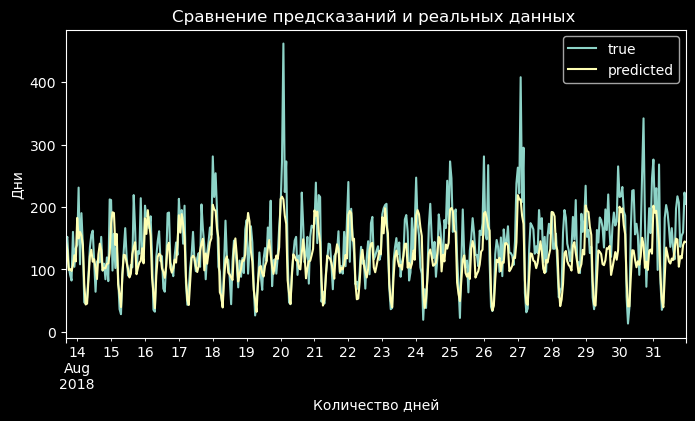

In [26]:
prediction = lgbm[0].predict(X_test)
rmse = mean_squared_error(y_test, prediction, squared=False)
print(f'RMSE на тестовой выборке: {rmse:.1f}')

prediction  = pd.Series(prediction , index=y_test.index)
plt.figure(figsize=(8, 4))
y_test.plot(label='true', title='Сравнение предсказаний и реальных данных ')
prediction .plot(label='predicted')
plt.legend()
plt.xlabel("Количество дней")
plt.ylabel('Дни')
plt.show()

Ну, порог мы преодолели,ошибки в предсказаниях из за сглаженных выбросов.

# Вывод:

* В ходе проекта провели анализ данных о заказах такси в аэропортах за полгода - с 1 марта по 31 августа 2018 года.
* Ресеплировали данный по часу,посмотрели линию тренда,сезонность.Выяснили что количество заказов меняется от дня недели и времени суток.
* Создали признаки со скользящим среднем в сутки и лагом в 2 часа
* Обучили три модели,для обучения использовали кросс валидаци TimeSeriesSplit
* Налущим образом показала себя модель lgbm.После чего провели проверку на тестовой выборке с rmse = 44,позволило преодолеть порог пл условию в 48